#Importación Librerías


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Proyecto Inteligencia Computacional/df_2.xlsx'
df = pd.read_excel(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,8))
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, decimals=3)

        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Tratamiento de Datos

Eliminamos las variables con mas de 150 valores nulos

In [30]:
df_copy = df.copy()
for i in df_copy:
  if df_copy[i].isna().sum() >= 150:
     df_copy = df_copy.drop(columns = [i]) 

Por lo tanto juntaremos clases las clases SNIIb, SNIIn y SNII en una sola clase puesto que tiene pocos ejemplos.

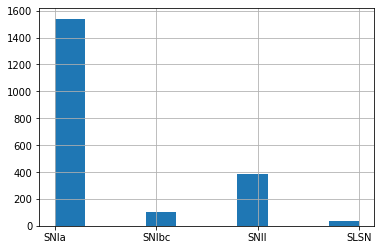

In [31]:
df_copy['classALeRCE']= df_copy['classALeRCE'].replace(['SNIIb','SNIIn'],'SNII')
df_copy['classALeRCE'].hist()
df_copy = df_copy.dropna()


Por último separamos el dataset en entrenamiento y testeo y además balanceamos los datos.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
Le = LabelEncoder()
X = df_copy.drop(columns = ['classALeRCE', 'oid'])
X = scaler.fit_transform(X)
y = df_copy['classALeRCE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)

# Random Forest con todos los Features

## Random Forest sin balance

Entrenaremos un modelo de Random Forest sin balancear.

In [33]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced')

model_RF.fit(X_train, y_train) 

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='sqrt', n_estimators=50, n_jobs=-1)

Veamos cómo se comporta este modelo con algunas métricas de error, como la matriz de confusión y la métrica balance accuracy.

Classification report SVC
              precision    recall  f1-score   support

        SLSN       1.00      0.09      0.17        11
        SNII       0.82      0.65      0.73       118
        SNIa       0.88      0.99      0.93       464
       SNIbc       0.00      0.00      0.00        27

    accuracy                           0.87       620
   macro avg       0.67      0.43      0.46       620
weighted avg       0.83      0.87      0.84       620

Normalized confusion matrix


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


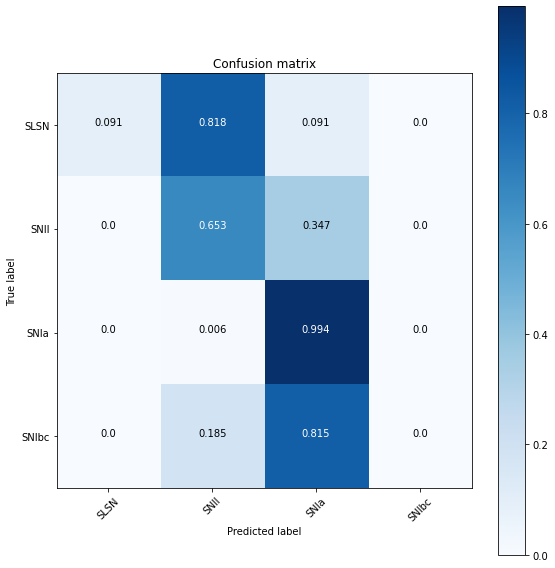

In [34]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

y_predict = model_RF.predict(X_test)

# Comparamos con classification_report
print('Classification report SVC')
print(classification_report(y_test, y_predict))
# Gráfica matriz de confusión
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, [*model_RF.classes_], normalize=True) 

Balance Accuracy Score modelo simple de RF

In [35]:
from sklearn.metrics import balanced_accuracy_score
print('Balance Accuracy Score modelo simple de RF: ', balanced_accuracy_score(y_test, y_predict))

Balance Accuracy Score modelo simple de RF:  0.4342464866372669


## Random Forest con balance

Ahora veremos cómo se comporta para un modelo de Balanced Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

model_B_RF = BalancedRandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced')

model_B_RF.fit(X_train, y_train) 

BalancedRandomForestClassifier(class_weight='balanced', max_depth=30,
                               max_features='sqrt', n_estimators=50, n_jobs=-1)

Veamos cómo se comporta este modelo con algunas métricas de error, como la matriz de confusión y la métrica balanced accuracy

Classification report SVC
              precision    recall  f1-score   support

        SLSN       0.19      0.73      0.30        11
        SNII       0.44      0.52      0.47       118
        SNIa       0.91      0.55      0.68       464
       SNIbc       0.04      0.26      0.07        27

    accuracy                           0.53       620
   macro avg       0.40      0.51      0.38       620
weighted avg       0.77      0.53      0.61       620

Normalized confusion matrix


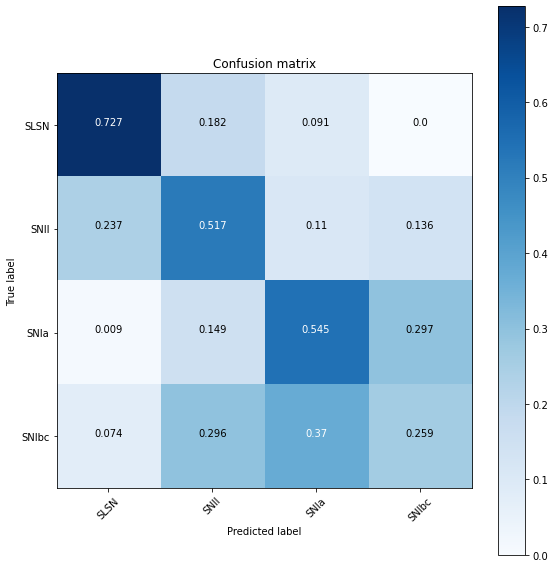

In [37]:
y_predict = model_B_RF.predict(X_test)
# Comparamos con classification_report
print('Classification report SVC')
print(classification_report(y_test, y_predict))
# Gráfica matriz de confusión
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, [*model_B_RF.classes_], normalize=True) 

Balance Accuracy Score modelo Balanced RF

In [38]:
from sklearn.metrics import balanced_accuracy_score
print('Balance Accuracy Score modelo Balanced RF: ', balanced_accuracy_score(y_test, y_predict))

Balance Accuracy Score modelo Balanced RF:  0.5121849399410036


# Random Forest con top 20 Features

## Selección Top 20

Ahora seleccionamos las 20 features mas relevantes y volvemos a correr los modelos con esas 20 features

In [39]:
from sklearn.model_selection import GridSearchCV
import time

start_time = time.time()
importances = model_B_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_B_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.026 seconds


In [40]:
importances

array([2.55094763e-03, 6.44110675e-02, 1.61568373e-02, 2.60056059e-03,
       1.07162936e-02, 1.04351110e-02, 0.00000000e+00, 1.30933558e-02,
       2.42409690e-04, 5.58778070e-03, 1.08739735e-02, 9.62232254e-03,
       1.05299769e-02, 9.20964957e-03, 8.78689946e-03, 0.00000000e+00,
       2.88735981e-03, 0.00000000e+00, 3.98614556e-03, 3.41637791e-03,
       9.04679061e-03, 1.11929937e-02, 2.47686033e-03, 2.37993956e-03,
       5.93597740e-03, 2.42923714e-03, 1.05738184e-02, 7.75165133e-03,
       1.95240773e-03, 7.17544578e-03, 0.00000000e+00, 2.33571501e-02,
       3.67694784e-03, 8.44206949e-03, 1.19859357e-02, 3.08331843e-04,
       1.01145006e-03, 1.07414671e-03, 3.85346356e-04, 6.15115688e-04,
       8.51284852e-04, 5.64008957e-04, 3.87023102e-03, 8.44640891e-03,
       8.00957399e-03, 7.51230711e-03, 8.01328532e-03, 1.00774117e-02,
       1.41506226e-02, 1.96234213e-18, 1.17565316e-03, 6.23370757e-05,
       0.00000000e+00, 1.84234877e-19, 1.24070797e-04, 5.07601250e-04,
      

In [41]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=feature_names)


important_features = pd.DataFrame()
important_features['valor importancia'] = forest_importances

important_features['variable'] = df_copy.drop(columns = ['classALeRCE', 'oid']).columns

important_features = important_features.sort_values(ascending = False, by = 'valor importancia')

important_features[:30]

,valor importancia,variable
feature 1,0.064411,delta_mjd_fid_g
feature 105,0.058427,SPM_tau_rise_r
feature 96,0.057237,SPM_t0_g
feature 102,0.033768,SPM_t0_r
feature 104,0.031622,SPM_beta_r
feature 94,0.030975,LinearTrend_r
feature 81,0.030070,PairSlopeTrend_r
feature 103,0.028280,SPM_gamma_r
feature 97,0.025446,SPM_gamma_g
feature 77,0.024101,Mean_r


Ahora corremos el modelos sólo con las 20 features más importantes.

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
scaler = StandardScaler()
Le = LabelEncoder()
top_20 = list(important_features['variable'][:20])
len(top_20)

20

In [43]:
df_filtrado  = df_copy[top_20]
X = df_filtrado
X = scaler.fit_transform(X)
y = df_copy['classALeRCE'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 


## Randon Forest sin balance

Entrenaremos un modelo de Random Forest sin balancear

In [44]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced')

model_RF.fit(X_train, y_train) 

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       max_features='sqrt', n_estimators=50, n_jobs=-1)

Veamos como se comporta este modelo con algunas metricas de error, como la matriz de confusion y la metrica balance accuracy

Classification report SVC
              precision    recall  f1-score   support

        SLSN       0.40      0.40      0.40         5
        SNII       0.82      0.57      0.67        99
        SNIa       0.87      0.99      0.93       432
       SNIbc       1.00      0.04      0.07        27

    accuracy                           0.86       563
   macro avg       0.77      0.50      0.52       563
weighted avg       0.87      0.86      0.84       563

Normalized confusion matrix


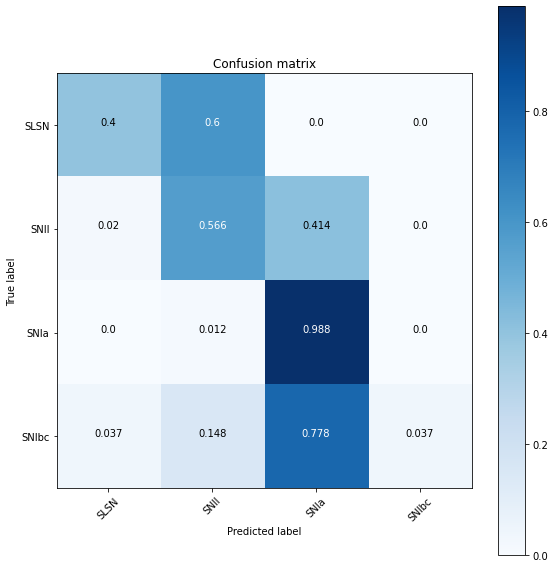

In [45]:
y_predict = model_RF.predict(X_test)
#Comparamos con classification_report
print('Classification report SVC')
print(classification_report(y_test, y_predict))
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, [*model_RF.classes_], normalize=True) 

Balance Accuracy Score modelo simple de RF

In [46]:
from sklearn.metrics import balanced_accuracy_score
print('Balance Accuracy Score modelo simple de RF: ', balanced_accuracy_score(y_test, y_predict))

Balance Accuracy Score modelo simple de RF:  0.49777988215488217


## Random Forest con balance

Ahora veremos cómo se comporta para un modelo de Balanced Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

model_B_RF = BalancedRandomForestClassifier(n_estimators=50,
    criterion='gini',
    max_depth=30,
    max_features='sqrt',
    n_jobs=-1,
    class_weight='balanced')

model_B_RF.fit(X_train, y_train) 

BalancedRandomForestClassifier(class_weight='balanced', max_depth=30,
                               max_features='sqrt', n_estimators=50, n_jobs=-1)

Veamos cómo se comporta este modelo con algunas métricas de error, como la matriz de confusión y la métrica balanced accuracy

Classification report SVC
              precision    recall  f1-score   support

        SLSN       0.17      1.00      0.29         5
        SNII       0.58      0.57      0.57        99
        SNIa       0.91      0.65      0.76       432
       SNIbc       0.07      0.33      0.12        27

    accuracy                           0.63       563
   macro avg       0.43      0.64      0.44       563
weighted avg       0.81      0.63      0.69       563

Normalized confusion matrix


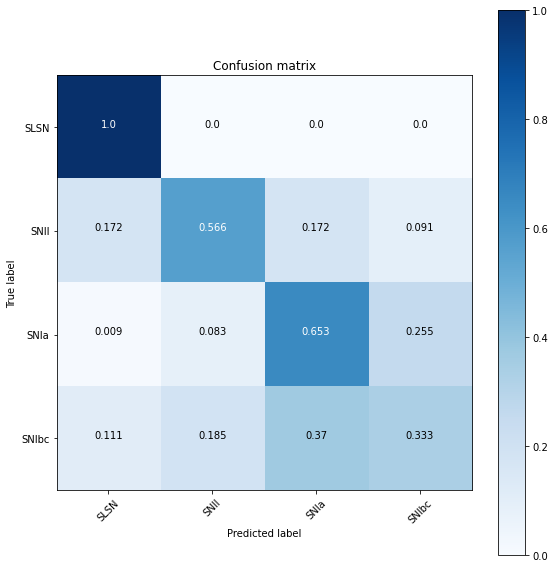

In [48]:
from sklearn import metrics
import seaborn as sns
y_predict = model_B_RF.predict(X_test)
#Comparamos con classification_report
print('Classification report SVC')
print(classification_report(y_test, y_predict))
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_predict)
plot_confusion_matrix(cm, [*model_B_RF.classes_], normalize=True) 

Balance Accuracy Score modelo Balanced RF

In [49]:
from sklearn.metrics import balanced_accuracy_score
print('Balance Accuracy Score modelo Balanced RF: ', balanced_accuracy_score(y_test, y_predict))

Balance Accuracy Score modelo Balanced RF:  0.6379419191919192


In [50]:
from sklearn.experimental import enable_halving_search_cv  
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif


params_svc = [{
    'Selection__percentile' : [60, 80, 90],
    'Clasificador__kernel' : ['linear', 'poly', 'rbf'],
    'Clasificador__decision_function_shape' : ['ovo', 'ovr'],
    'Clasificador__class_weight': [None, 'balanced'],
}]




param_rf = [{
    'Selection__percentile' : [60, 80, 90],
    'Clasificador__n_estimators' : [80, 100, 120],
    'Clasificador__criterion' : ['gini', 'entropy'],
    'Clasificador__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'Clasificador__class_weight': ['balanced', 'balanced_subsample', None]

}]


params_balanced_rf = [{
    'Selection__percentile' : [60, 80, 90],
    'Clasificador__criterion' : ['gini', 'entropy'],
    'Clasificador__n_estimators' : [80, 100, 120],
    'Clasificador__max_depth': [3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'Clasificador__class_weight': ['balanced', 'balanced_subsample', None]
    

}]

In [51]:
model_svc = Pipeline(steps=[
                           ("Selection", SelectPercentile(f_classif, percentile=90)),
                           ('Clasificador', SVC())
])




model_rf = Pipeline(steps=[
                           ("Selection", SelectPercentile(f_classif, percentile=90)),
                           ('Clasificador', RandomForestClassifier())

])


model_balanced_rf = Pipeline(steps=[
                           ("Selection", SelectPercentile(f_classif, percentile=90)),
                           ('Clasificador', BalancedRandomForestClassifier())
])

In [52]:
model_svc.get_params()

{'memory': None,
 'steps': [('Selection', SelectPercentile(percentile=90)),
  ('Clasificador', SVC())],
 'verbose': False,
 'Selection': SelectPercentile(percentile=90),
 'Clasificador': SVC(),
 'Selection__percentile': 90,
 'Selection__score_func': <function sklearn.feature_selection._univariate_selection.f_classif(X, y)>,
 'Clasificador__C': 1.0,
 'Clasificador__break_ties': False,
 'Clasificador__cache_size': 200,
 'Clasificador__class_weight': None,
 'Clasificador__coef0': 0.0,
 'Clasificador__decision_function_shape': 'ovr',
 'Clasificador__degree': 3,
 'Clasificador__gamma': 'scale',
 'Clasificador__kernel': 'rbf',
 'Clasificador__max_iter': -1,
 'Clasificador__probability': False,
 'Clasificador__random_state': None,
 'Clasificador__shrinking': True,
 'Clasificador__tol': 0.001,
 'Clasificador__verbose': False}

In [53]:
model_svc = HalvingGridSearchCV(model_svc, params_svc, random_state = 0, scoring = 'balanced_accuracy').fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_clas

In [54]:
model_rf = HalvingGridSearchCV(model_rf, param_rf, random_state = 0, scoring = 'balanced_accuracy').fit(X_train,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_clas

In [55]:
model_balanced_rf = HalvingGridSearchCV(model_balanced_rf, params_balanced_rf, random_state = 0, scoring = 'balanced_accuracy').fit(X_train,y_train)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_

In [56]:
model_svc.best_estimator_

Pipeline(steps=[('Selection', SelectPercentile(percentile=80)),
                ('Clasificador',
                 SVC(class_weight='balanced', kernel='linear'))])

Balanced Accuracy model svc:  0.6247895622895623
              precision    recall  f1-score   support

        SLSN       0.14      1.00      0.24         5
        SNII       0.52      0.43      0.47        99
        SNIa       0.92      0.66      0.77       432
       SNIbc       0.08      0.41      0.14        27

    accuracy                           0.61       563
   macro avg       0.41      0.62      0.40       563
weighted avg       0.80      0.61      0.68       563

Mejores Parametros SVC
Pipeline(steps=[('Selection', SelectPercentile(percentile=80)),
                ('Clasificador',
                 SVC(class_weight='balanced', kernel='linear'))])
Matriz de Confusion
Normalized confusion matrix


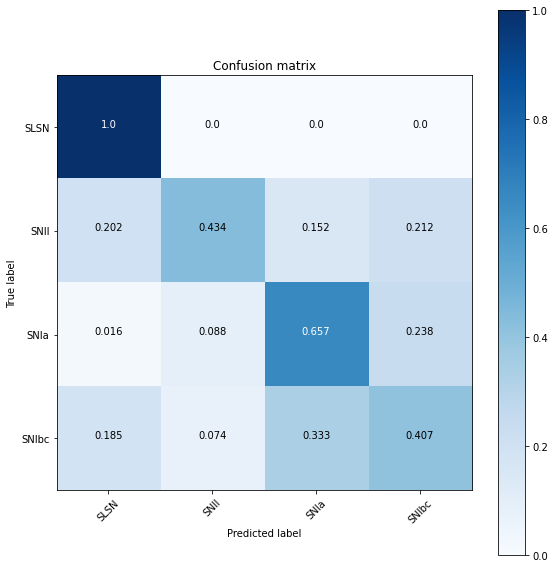

-----------------------------------------------------------------------------------
Balanced Accuracy model rf:  0.6190025252525253
              precision    recall  f1-score   support

        SLSN       0.23      1.00      0.37         5
        SNII       0.55      0.55      0.55        99
        SNIa       0.89      0.71      0.79       432
       SNIbc       0.06      0.22      0.09        27

    accuracy                           0.66       563
   macro avg       0.43      0.62      0.45       563
weighted avg       0.79      0.66      0.71       563

Mejores Parametros RF
Pipeline(steps=[('Selection', SelectPercentile(percentile=90)),
                ('Clasificador',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy', max_depth=3,
                                        n_estimators=120))])
Normalized confusion matrix


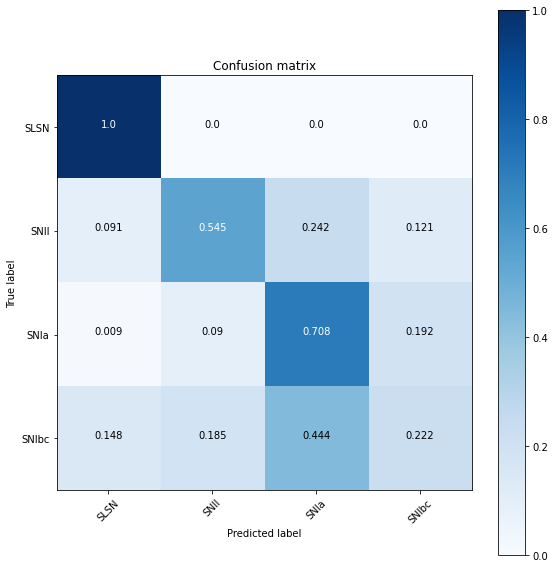

-----------------------------------------------------------------------------------
Balanced Accuracy model  balanced rf:  0.6212121212121212
              precision    recall  f1-score   support

        SLSN       0.14      1.00      0.24         5
        SNII       0.62      0.48      0.55        99
        SNIa       0.93      0.63      0.75       432
       SNIbc       0.06      0.37      0.11        27

    accuracy                           0.60       563
   macro avg       0.44      0.62      0.41       563
weighted avg       0.83      0.60      0.68       563

Mejores Parametros  Balanced RF
Pipeline(steps=[('Selection', SelectPercentile(percentile=80)),
                ('Clasificador',
                 BalancedRandomForestClassifier(max_depth=30,
                                                n_estimators=120))])
Normalized confusion matrix


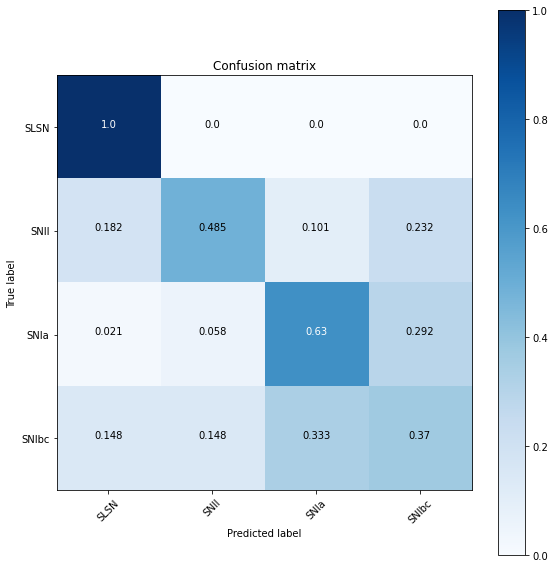

In [57]:
y_pred_svc = model_svc.predict(X_test)
#Comparamos con classification_report
print('Balanced Accuracy model svc: ', balanced_accuracy_score(y_test, y_pred_svc) )
print(classification_report(y_test, y_pred_svc))
print('Mejores Parametros SVC')
print(model_svc.best_estimator_)
print('Matriz de Confusion')
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix(cm, [*model_svc.classes_], normalize=True)

print('-----------------------------------------------------------------------------------')

y_pred_rf = model_rf.predict(X_test)
#Comparamos con classification_report
print('Balanced Accuracy model rf: ', balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print('Mejores Parametros RF')
print(model_rf.best_estimator_)
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm, [*model_rf.classes_], normalize=True)

print('-----------------------------------------------------------------------------------')


y_pred_balanced_rf = model_balanced_rf.predict(X_test)
print('Balanced Accuracy model  balanced rf: ', balanced_accuracy_score(y_test, y_pred_balanced_rf))
print(classification_report(y_test, y_pred_balanced_rf))
print('Mejores Parametros  Balanced RF')
print(model_balanced_rf.best_estimator_)
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_balanced_rf)
plot_confusion_matrix(cm, [*model_balanced_rf.classes_], normalize=True)

In [ ]:
model_rf.best_estimator_

In [ ]:
# Predecimos
y_pred_rf = model_rf.predict(X_test)
#Comparamos con classification_report
print('Classification report RF')
print(classification_report(y_test, y_pred_rf))
# gráficar matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm, [*model_rf.classes_], normalize=True)

# MLP con top 20 Features


Importamos las librerías necesarias para armar el modelo.

In [ ]:
#librerias necesarias para Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

Se crea la red neuronal (esqueleto) para aplicar con los modelos a entrenar.

In [ ]:
# Se procede a crear una red neuronal tipo MLP.
def mi_red(num_hidden_layers, 
           num_neurons_per_layer, 
           dropout_rate,
           activation,
           n_var):
  
  # Capa de entrada
  inputs = tf.keras.Input(shape = (n_var.shape[1],))

  x = tf.keras.layers.Dropout(dropout_rate)(inputs) 

  # Capas ocultas
  for i in range(num_hidden_layers):
    x = tf.keras.layers.Dense(num_neurons_per_layer[i], activation = activation)(x)
    
    x = tf.keras.layers.Dropout(dropout_rate)(x)
  
  # Capa de salida

  outputs = tf.keras.layers.Dense(4, activation = 'sigmoid')(x)

  # Se crea el modelo con el input y los outputs.
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

def graficos_entreno(metrica, h):

  # Se crea la figura.
  f = plt.figure()

  # Se procede a graficar la métrica ingresada.
  plt.plot(h.history[metrica])
  plt.plot(h.history['val_{}'.format(metrica)])

  # Se realizan las anotaciones del gráfico.
  plt.title('model {}'.format(metrica))
  plt.ylabel(metrica)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  return f

In [ ]:
#Ahora convertiremos nuestras variables objetivo en categorias, para poder entrenar nuestro modelo, puesto que keras no acepta variables numericas como variables objetivo para clasificacion.
y_train = pd.get_dummies(y_train, columns = ['classALeRCE'])
y_test = pd.get_dummies(y_test, columns = ['classALeRCE'])

## Modelo 1

In [ ]:
modelo_tarea = mi_red(num_hidden_layers = 2, 
                   num_neurons_per_layer = [20,20], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

In [ ]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

In [ ]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('accuracy', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()

## Modelo 2

In [ ]:
modelo_tarea = mi_red(num_hidden_layers = 5, 
                   num_neurons_per_layer = [20,20,20,10,10], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

In [ ]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 128.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

In [ ]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('accuracy', history_tarea)
plt.show()

f4 = graficos_entreno('loss', history_tarea)
plt.show()

## Modelo 3

In [ ]:
modelo_tarea = mi_red(num_hidden_layers = 2, 
                   num_neurons_per_layer = [40,40], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

In [ ]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 1000, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

In [ ]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('accuracy', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()

## Modelo 4

In [ ]:
modelo_tarea = mi_red(num_hidden_layers = 5, 
                   num_neurons_per_layer = [100,80,60,40,20], 
                   dropout_rate = 0.1, 
                   activation = 'relu',
                   n_var = X_train)
modelo_tarea.summary()

In [ ]:
# Se plantea un método de regularización como un early stopper.
early_stopping_monitor = EarlyStopping(patience = 10)

# Se utiliza un optimizador como Adam, con el learning rate indicado.
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)

# Se compila el modelo, donde se plantea un binary_crossentropy debido al tipo de problema. Y se utiliza la métrica correspondiente binary_accuracy y recall dado el desbalanceo de datos.
modelo_tarea.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

# Se entrena la red, con una cantidad de épocas máxima de 100, en general se detiene antes por el early_stopper. Además, se utiliza un batch de 256.
history_tarea = modelo_tarea.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, verbose = 1, batch_size = 128, callbacks= early_stopping_monitor)

In [ ]:
# Se procede a graficar las iteraciones.

f1 = graficos_entreno('accuracy', history_tarea)
plt.show()


f4 = graficos_entreno('loss', history_tarea)
plt.show()